--- 1. CONFIGURACIÓN DEL EJEMPLO ---
Datos de entrenamiento (X, Y, Tag):
  Z_1 = (80m^2, €180k, día 1)
  Z_2 = (100m^2, €200k, día 2)
  Z_3 = (120m^2, €230k, día 3)
  Z_4 = (150m^2, €280k, día 4)
Punto de prueba: X_5 = 110m^2, Tag = día 5
Factor de decaimiento rho: 0.8
Pesos de calibración originales (sin normalizar): [0.512 0.64  0.8   1.   ]
Peso del punto de prueba (sin normalizar): 1.0
Nivel de significancia alpha: 0.1 (para un 90% de cobertura)
  Inicializado Algoritmo No Simétrico: Regresión Lineal Ponderada por Tag Temporal.

--- 2. INICIO DEL PROCESO DE PREDICCIÓN CONFORME ---
  Pesos conformal normalizados (w̃_i): [0.12955466 0.16194332 0.20242915 0.25303644 0.25303644]

  Iterando sobre 20 etiquetas hipotéticas para Y_5:

  --- Iteración para y_hip = 130.00 ---
    Paso de Intercambio Aleatorio: K_orig = 2
    Tags Originales: [1 2 3 4 5]
    Tags para Ajuste (después del swap K_orig=2): [1 2 5 4 3]
    Ajustando modelo A con y_hip=130.00 y tags intercambiados (K_orig=2)...
 

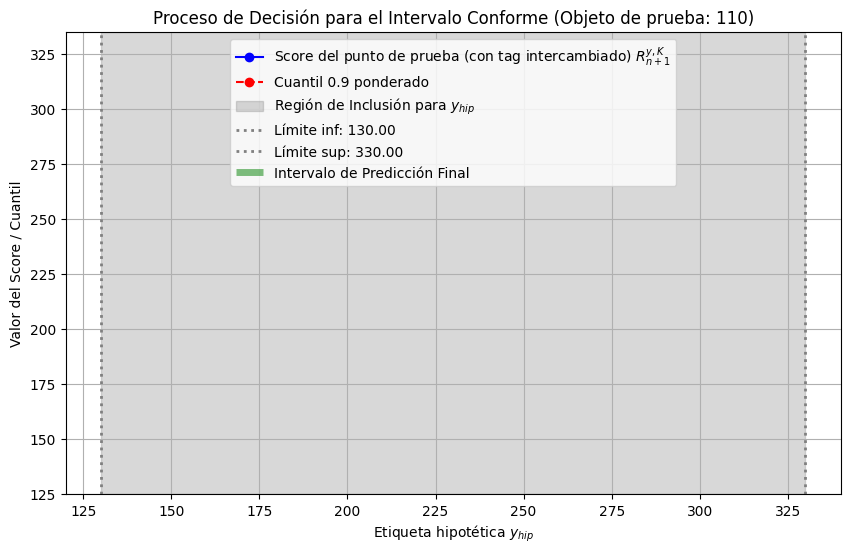


Para visualizar el proceso de decisión:
 - Grafica 'y_plot' en el eje x.
 - Grafica 'scores_plot' (azul) y 'quantiles_plot' (rojo) en el eje y.
 - El intervalo de predicción final (si es acotado) está marcado por las líneas verticales grises y la línea verde horizontal.
 - El área gris indica los valores de y_hip que se incluirían en el conjunto de predicción.


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt # Para graficar (si ejecutas esto en un entorno adecuado)

# --- Configuración del Ejemplo ---
print("--- 1. CONFIGURACIÓN DEL EJEMPLO ---")
# Datos de entrenamiento/calibración originales (X, Y, Tags)
X_train_orig = np.array([[80], [100], [120], [150]]) # Metros cuadrados
Y_train_orig = np.array([180, 200, 230, 280])     # Precios en miles de €
T_train_orig = np.array([1, 2, 3, 4])             # Tags: día 1, día 2, día 3, día 4
n_calib = len(X_train_orig)
print(f"Datos de entrenamiento (X, Y, Tag):")
for i in range(n_calib):
    print(f"  Z_{i+1} = ({X_train_orig[i][0]}m^2, €{Y_train_orig[i]}k, día {T_train_orig[i]})")

# Punto de prueba (objeto y su tag)
X_test_obj = np.array([[110]])
T_test_obj_tag = np.array([n_calib + 1]) # Tag: día 5 (siguiente al último de entrenamiento)
print(f"Punto de prueba: X_{n_calib+1} = {X_test_obj[0][0]}m^2, Tag = día {T_test_obj_tag[0]}")

# Pesos con decaimiento exponencial
# w_i = rho^(antigüedad), donde antigüedad = (tag_mas_reciente - tag_i)
# El punto de prueba (o el que ocupa su lugar) tiene antigüedad 0, peso rho^0 = 1
rho = 0.8 # Factor de decaimiento (más cercano a 1, menos decaimiento)
weights_orig_calib = rho**((T_test_obj_tag[0]-1) - T_train_orig) # Pesos para los puntos de entrenamiento
weight_test_point = 1.0 # Peso para el punto de prueba antes de normalizar
print(f"Factor de decaimiento rho: {rho}")
print(f"Pesos de calibración originales (sin normalizar): {weights_orig_calib}")
print(f"Peso del punto de prueba (sin normalizar): {weight_test_point}")

# Nivel de significancia
alpha = 0.1
print(f"Nivel de significancia alpha: {alpha} (para un {100*(1-alpha):.0f}% de cobertura)")

# --- Algoritmo de Aprendizaje No Simétrico (Ejemplo Simplificado) ---
# Regresión lineal donde el peso de un punto (x_i, y_i) con tag t_i
# es su propio tag t_i (más reciente = más peso numérico = más influencia)
class NonSymmetricTimeLR:
    def __init__(self):
        self.model = LinearRegression()
        print("  Inicializado Algoritmo No Simétrico: Regresión Lineal Ponderada por Tag Temporal.")

    def fit(self, X_tagged_data, Y_data):
        tags = np.array([data[1] for data in X_tagged_data])
        features = np.array([data[0] for data in X_tagged_data])

        if len(tags) == 0:
            class DummyModel:
                def predict(self, X): return np.zeros(len(X))
            self.model = DummyModel()
            return

        sample_weights_for_lr = tags.astype(float)
        if np.sum(sample_weights_for_lr) > 0:
             sample_weights_for_lr = sample_weights_for_lr / np.sum(sample_weights_for_lr) * len(sample_weights_for_lr)
        else:
            sample_weights_for_lr = np.ones_like(sample_weights_for_lr)

        features_reshaped = features.reshape(-1, features.shape[-1] if features.ndim > 1 else 1)
        self.model.fit(features_reshaped, Y_data, sample_weight=sample_weights_for_lr)

    def predict(self, X_features):
        X_features_reshaped = X_features.reshape(-1, X_features.shape[-1] if X_features.ndim > 1 else 1)
        return self.model.predict(X_features_reshaped)

algorithm_A = NonSymmetricTimeLR()

# --- Función para calcular el score de no conformidad ---
def non_conformity_score(y_true, y_pred):
    return np.abs(y_true - y_pred)

# --- Proceso de Predicción Conforme Completa No Intercambiable ---
print("\n--- 2. INICIO DEL PROCESO DE PREDICCIÓN CONFORME ---")

def non_exchangeable_full_conformal_prediction_verbose(
    X_calib_orig, Y_calib_orig, T_calib_orig,
    X_test_obj_orig, T_test_obj_tag_orig,
    weights_calib_orig, weight_test_point_orig,
    algo_A, alpha_level, num_y_hipoteticas=20 # Menos para brevedad
):
    n_calib = len(X_calib_orig)
    all_X_orig_ordered = np.vstack([X_calib_orig, X_test_obj_orig])
    all_T_orig_ordered = np.concatenate([T_calib_orig, T_test_obj_tag_orig])

    sum_weights_total = np.sum(weights_calib_orig) + weight_test_point_orig
    weights_normalized = np.concatenate([weights_calib_orig, [weight_test_point_orig]]) / sum_weights_total
    print(f"  Pesos conformal normalizados (w̃_i): {weights_normalized}")

    # Definición de y_range_padding
    if len(Y_calib_orig) > 1:
        y_range_padding = (np.max(Y_calib_orig) - np.min(Y_calib_orig)) * 0.5
        if y_range_padding == 0: # En caso de que todos los Y_calib_orig sean iguales
            y_range_padding = np.abs(np.mean(Y_calib_orig)) * 0.5 if np.mean(Y_calib_orig) != 0 else 10.0
    elif len(Y_calib_orig) == 1:
        y_range_padding = np.abs(Y_calib_orig[0]) * 0.5 if Y_calib_orig[0] != 0 else 10.0
    else: # No hay datos de calibración, difícil establecer un rango significativo
        y_range_padding = 50.0 # Un valor arbitrario
        min_y_calib_for_range = 150 # Valor arbitrario
        max_y_calib_for_range = 250 # Valor arbitrario

    if len(Y_calib_orig) > 0:
        min_y_calib_for_range = np.min(Y_calib_orig)
        max_y_calib_for_range = np.max(Y_calib_orig)


    y_hipoteticas = np.linspace(min_y_calib_for_range - y_range_padding,
                                max_y_calib_for_range + y_range_padding,
                                num_y_hipoteticas)
    prediction_set_y_values = []
    all_test_point_scores_after_swap = []
    all_quantiles = []

    print(f"\n  Iterando sobre {num_y_hipoteticas} etiquetas hipotéticas para Y_{n_calib+1}:")
    for idx_y_hip, y_hip in enumerate(y_hipoteticas):
        print(f"\n  --- Iteración para y_hip = {y_hip:.2f} ---")
        current_Y_augmented_orig = np.concatenate([Y_calib_orig, [y_hip]])

        possible_indices_orig = np.arange(n_calib + 1)
        K_orig = np.random.choice(possible_indices_orig, p=weights_normalized)
        print(f"    Paso de Intercambio Aleatorio: K_orig = {K_orig}")

        X_for_fitting = all_X_orig_ordered.copy()
        Y_for_fitting = current_Y_augmented_orig.copy()
        T_for_fitting = all_T_orig_ordered.copy()

        original_tag_at_K = all_T_orig_ordered[K_orig]
        original_tag_at_test = all_T_orig_ordered[n_calib]

        T_for_fitting[K_orig] = original_tag_at_test
        T_for_fitting[n_calib] = original_tag_at_K
        print(f"    Tags Originales: {all_T_orig_ordered}")
        print(f"    Tags para Ajuste (después del swap K_orig={K_orig}): {T_for_fitting}")

        tagged_features_for_A = []
        for i in range(n_calib + 1):
            tagged_features_for_A.append((X_for_fitting[i].reshape(1,-1), T_for_fitting[i]))

        print(f"    Ajustando modelo A con y_hip={y_hip:.2f} y tags intercambiados (K_orig={K_orig})...")
        algo_A.fit(tagged_features_for_A, Y_for_fitting)

        scores_after_swap = np.zeros(n_calib + 1)
        for i in range(n_calib + 1):
            y_pred_i = algo_A.predict(X_for_fitting[i].reshape(1,-1))[0]
            scores_after_swap[i] = non_conformity_score(Y_for_fitting[i], y_pred_i)
        print(f"    Scores de No Conformidad (R_i^{{y_hip, K_orig}}) para Z^K: {np.round(scores_after_swap, 2)}")

        score_of_interest_for_test_point = scores_after_swap[K_orig]
        all_test_point_scores_after_swap.append(score_of_interest_for_test_point)
        print(f"    Score de interés para y_hip={y_hip:.2f} (R_{{n+1}}^{{y,K}} usando K_orig={K_orig}): {score_of_interest_for_test_point:.4f}")

        sorted_indices = np.argsort(scores_after_swap)
        sorted_scores = scores_after_swap[sorted_indices]
        sorted_weights = weights_normalized[sorted_indices]
        cumulative_weights = np.cumsum(sorted_weights)

        quantile_idx = np.where(cumulative_weights >= (1 - alpha_level))[0]
        quantile_value = np.inf if len(quantile_idx) == 0 else sorted_scores[quantile_idx[0]]
        all_quantiles.append(quantile_value)
        print(f"    Cuantil_{{{1-alpha_level:.2f}}} ponderado de scores: {quantile_value:.4f}")

        if score_of_interest_for_test_point <= quantile_value:
            prediction_set_y_values.append(y_hip)
            print(f"    DECISIÓN: y_hip = {y_hip:.2f} INCLUIDO en el conjunto de predicción.")
        else:
            print(f"    DECISIÓN: y_hip = {y_hip:.2f} EXCLUIDO del conjunto de predicción.")

    print("\n--- 3. RESULTADO FINAL ---")
    if not prediction_set_y_values:
        print("El conjunto de predicción es vacío.")
        final_interval = (-np.inf, np.inf)
    else:
        final_interval = (np.min(prediction_set_y_values), np.max(prediction_set_y_values))
        print(f"Conjunto de predicción final para X_{n_calib+1}={X_test_obj[0][0]}m^2 (cobertura deseada {100*(1-alpha_level):.0f}%): [{final_interval[0]:.2f}, {final_interval[1]:.2f}]")

    # Para graficar
    if len(Y_calib_orig) == 0: # Necesario para el rango de y_plot
        y_range_padding = 50.0
        min_y_calib_for_range = 150
        max_y_calib_for_range = 250

    return final_interval, y_hipoteticas, all_test_point_scores_after_swap, all_quantiles, y_range_padding, min_y_calib_for_range, max_y_calib_for_range


# --- Ejecutar el ejemplo ---
np.random.seed(42)
intervalo_pred, y_plot, scores_plot, quantiles_plot, y_range_padding_val, min_y_calib_val, max_y_calib_val = \
    non_exchangeable_full_conformal_prediction_verbose(
        X_train_orig, Y_train_orig, T_train_orig,
        X_test_obj, T_test_obj_tag,
        weights_orig_calib, weight_test_point,
        algorithm_A, alpha
    )

# --- Graficación Conceptual (ejecutar en un entorno con matplotlib) ---
plt.figure(figsize=(10, 6))
plt.plot(y_plot, scores_plot, 'bo-', label='Score del punto de prueba (con tag intercambiado) $R_{n+1}^{y,K}$')
plt.plot(y_plot, quantiles_plot, 'ro--', label=f'Cuantil {1-alpha:.1f} ponderado')

# Usar los valores devueltos para el fill_between
min_plot_y_limit = min_y_calib_val - y_range_padding_val * 1.1 # Un poco más de margen
max_plot_y_limit = max_y_calib_val + y_range_padding_val * 1.1

# Llenar el área donde el score es menor o igual al cuantil
plt.fill_between(y_plot,
                 np.where(np.array(scores_plot) <= np.array(quantiles_plot), min_plot_y_limit, max_plot_y_limit), # Límite inferior del área sombreada
                 np.where(np.array(scores_plot) <= np.array(quantiles_plot), max_plot_y_limit, min_plot_y_limit), # Límite superior del área sombreada
                 color='gray', alpha=0.3, label=f'Región de Inclusión para $y_{{hip}}$')


if intervalo_pred[0] != -np.inf and intervalo_pred[1] != np.inf : # Solo dibujar si el intervalo es finito
    plt.axvline(intervalo_pred[0], color='gray', linestyle=':', linewidth=2, label=f'Límite inf: {intervalo_pred[0]:.2f}')
    plt.axvline(intervalo_pred[1], color='gray', linestyle=':', linewidth=2, label=f'Límite sup: {intervalo_pred[1]:.2f}')
    plt.hlines(0, intervalo_pred[0], intervalo_pred[1], colors='green', lw=5, alpha=0.5, label=f'Intervalo de Predicción Final')


plt.xlabel("Etiqueta hipotética $y_{hip}$")
plt.ylabel("Valor del Score / Cuantil")
plt.title(f"Proceso de Decisión para el Intervalo Conforme (Objeto de prueba: {X_test_obj[0][0]})")
plt.legend(loc='upper center')
plt.grid(True)
plt.ylim(min_plot_y_limit, max_plot_y_limit) # Ajustar límites del eje Y de la gráfica
plt.show()

print("\nPara visualizar el proceso de decisión:")
print(" - Grafica 'y_plot' en el eje x.")
print(" - Grafica 'scores_plot' (azul) y 'quantiles_plot' (rojo) en el eje y.")
print(" - El intervalo de predicción final (si es acotado) está marcado por las líneas verticales grises y la línea verde horizontal.")
print(" - El área gris indica los valores de y_hip que se incluirían en el conjunto de predicción.")